In [1]:
## Two-Class EEG Classification using LSTM-based RNN
## Here, we develop a baseline model for using an RNN to perform time-series prediction for one of two motor
## imagery (MI) tasks. The data from the file CLA_SubjectJ-170508-3St-LRHand-Inter.mat is processed and we
## only keep the data points that pertain to the left and right hand MI tasks. Each of the MI task data consists
## of 170 time steps, with each time step consisting of 22 inputs. In other words, we pass the current sample for
## of the 22 channels for each time step. At the end of the 170 time step, we send the output of the LSTM layers
## to a Dense layer with two outputs. To ease the classification at the outer layer, we have converted the class
## into a one-hot encoding of zeros and ones, and use the sigmoid unit at the output to match the output range.

## Preliminary results:
## Performance on training set is 100% classification rate after around 30 to 40 epochs.
## Performance on test set is around 60% - 68%.

## Potential problems:
## The total amount of data is relatively low. Can it be possible to combine multiple subject's L/R Hand MI data
## into one unified data set?
## Can also possible increase the size of the data set by doing some data augmentations.
## For example, injecting some noise into the existing EEG data to create more test data?

## Followup/TODO:
## Use pre-implemented common spatial patterns for feature extraction: avialable here: https://github.com/spolsley/common-spatial-patterns
## Try using a relatively simple non-linear energy operator as a pre-emphasis step on the data to see if it helps generalize
## the model.

In [2]:
## This file is used to split data into series of arrays and their corresponding MI task.
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
file = sio.loadmat('dataset/CLA/CLA-SubjectJ-170508-3St-LRHand-Inter.mat') #replace with .mat file name
header=file['__header__']
version=file['__version__']
glob=file['__globals__']
ans=file['ans']


x=file['x']
o=file['o'][0][0]
data=o['data']
data = np.transpose(data)
data = data[0:21,:]
print(data)
nS=o['nS'][0][0]
#values of structure seem to be 2D numpy arrays, if originally a scalar in Matlab.
#use [0][0] to get scalar.
print("Number of samples: {numSamples}".format(numSamples=nS))
test=o['id'][0] #id value became a 1D array of size 1 for some reason. use [0] to get value
print("Dataset ID: {id}".format(id=test))
chnames=o['chnames'][:,0] #[:,0] converts from 2D array back to 1D array
print("Channel names: {channelNames}".format(channelNames=chnames))
markers = o['marker']
## The markers are all still individual arrays of size 1x1, so we convert them to an array with single values
markersArray = []
for marker in markers:
    markersArray.append(marker[0])
markersArray = np.asarray(markersArray)
#For this dataset, the markers are 0, 1, or 2.
# 1 - Left Hand MI, 2 - Right Hand MI, 3 - Passive State, 0 - Rest (???)

[[-18.   -3.6  -6.6 ...  -9.   -7.2  -2.4]
 [-19.2  -0.   -8.4 ...  -8.4 -11.4  -9. ]
 [-12.    1.8  -1.2 ...   2.4   3.6   5.4]
 ...
 [ -7.2   7.2   1.8 ...   1.8   4.2   4.2]
 [ -6.    5.4   3.  ...   5.4   4.2   3.6]
 [ -8.4   7.2   3.  ...   4.8   6.6   6. ]]
Number of samples: 621892
Dataset ID: 201705081338.32BEA9DD
Channel names: [array(['Fp1'], dtype='<U3') array(['Fp2'], dtype='<U3')
 array(['F3'], dtype='<U2') array(['F4'], dtype='<U2')
 array(['C3'], dtype='<U2') array(['C4'], dtype='<U2')
 array(['P3'], dtype='<U2') array(['P4'], dtype='<U2')
 array(['O1'], dtype='<U2') array(['O2'], dtype='<U2')
 array(['A1'], dtype='<U2') array(['A2'], dtype='<U2')
 array(['F7'], dtype='<U2') array(['F8'], dtype='<U2')
 array(['T3'], dtype='<U2') array(['T4'], dtype='<U2')
 array(['T5'], dtype='<U2') array(['T6'], dtype='<U2')
 array(['Fz'], dtype='<U2') array(['Cz'], dtype='<U2')
 array(['Pz'], dtype='<U2')]


In [3]:
## CSP File from: https://github.com/spolsley/common-spatial-patterns
# CSP takes any number of arguments, but each argument must be a collection of trials associated with a task
# That is, for N tasks, N arrays are passed to CSP each with dimensionality (# of trials of task N) x (feature vector)
# Trials may be of any dimension, provided that each trial for each task has the same dimensionality,
# otherwise there can be no spatial filtering since the trials cannot be compared
def CSP(*tasks):
	if len(tasks) < 2:
		print("Must have at least 2 tasks for filtering.")
		return (None,) * len(tasks)
	else:
		filters = ()
		# CSP algorithm
		# For each task x, find the mean variances Rx and not_Rx, which will be used to compute spatial filter SFx
		iterator = range(0,len(tasks))
		for x in iterator:
			# Find Rx
			Rx = covarianceMatrix(tasks[x][0])
			for t in range(1,len(tasks[x])):
				Rx += covarianceMatrix(tasks[x][t])
			Rx = Rx / len(tasks[x])

			# Find not_Rx
			count = 0
			not_Rx = Rx * 0
			for not_x in [element for element in iterator if element != x]:
				for t in range(0,len(tasks[not_x])):
					not_Rx += covarianceMatrix(tasks[not_x][t])
					count += 1
			not_Rx = not_Rx / count

			# Find the spatial filter SFx
			SFx = spatialFilter(Rx,not_Rx)
			filters += (SFx,)

			# Special case: only two tasks, no need to compute any more mean variances
			if len(tasks) == 2:
				filters += (spatialFilter(not_Rx,Rx),)
				break
		return filters

# covarianceMatrix takes a matrix A and returns the covariance matrix, scaled by the variance
def covarianceMatrix(A):
	Ca = np.dot(A,np.transpose(A))/np.trace(np.dot(A,np.transpose(A)))
	return Ca

# spatialFilter returns the spatial filter SFa for mean covariance matrices Ra and Rb
def spatialFilter(Ra,Rb):
	R = Ra + Rb
	E,U = la.eig(R)

	# CSP requires the eigenvalues E and eigenvector U be sorted in descending order
	ord = np.argsort(E)
	ord = ord[::-1] # argsort gives ascending order, flip to get descending
	E = E[ord]
	U = U[:,ord]

	# Find the whitening transformation matrix
	P = np.dot(np.sqrt(la.inv(np.diag(E))),np.transpose(U))

	# The mean covariance matrices may now be transformed
	Sa = np.dot(P,np.dot(Ra,np.transpose(P)))
	Sb = np.dot(P,np.dot(Rb,np.transpose(P)))

	# Find and sort the generalized eigenvalues and eigenvector
	E1,U1 = la.eig(Sa,Sb)
	ord1 = np.argsort(E1)
	ord1 = ord1[::-1]
	E1 = E1[ord1]
	U1 = U1[:,ord1]

	# The projection matrix (the spatial filter) may now be obtained
	SFa = np.dot(np.transpose(U1),P)
	return SFa.astype(np.float32)

In [4]:
## Find the starting indeces where the marker changes
changeIdxs = np.where(np.transpose(markersArray)[:-1] != np.transpose(markersArray)[1:])[0]
print("Number of index changes: {idxChanges}".format(idxChanges=changeIdxs.shape[0]))
## Split the data so that it has its matching marker
dataSplit = np.array_split(data, changeIdxs[:-1], axis=1)
splitCount = 0
for splitData in dataSplit:
    splitCount += 1
print("Number of arrays in data split: {num}".format(num=splitCount))
## Retrieve the marker values for each of the change indeces (changeIdxs)
markerTargets = markersArray[changeIdxs];
print("Number of marker targets: {numTargets}".format(numTargets=markerTargets.shape[0]))

Number of index changes: 1800
Number of arrays in data split: 1800
Number of marker targets: 1800


In [5]:
## To Apply CSP, we first only get the indeces for MI tasks 1 and 2 (left and right hand, respectively.)
LeftIdxs = np.where(markerTargets == 1)
RightIdxs = np.where(markerTargets == 2)
NoneIdxs = np.where(markerTargets == 3)
numLeftIdx = LeftIdxs[0].shape

In [6]:
leftData = [];
for leftIndex in LeftIdxs[0]:
    #print(leftIndex)
    #print("Dimensions of index: {ind}".format(ind=dataSplit[leftIndex].shape))
    if(dataSplit[leftIndex].shape[1] != 170):
        continue
    else:
        leftData.append(np.transpose(dataSplit[leftIndex]))
leftData = np.asarray(leftData)
leftData.shape

(288, 170, 21)

In [7]:
rightData = [];
for rightIndex in RightIdxs[0]:
    #print(leftIndex)
    #print("Dimensions of index: {ind}".format(ind=dataSplit[leftIndex].shape))
    if(dataSplit[rightIndex].shape[1] != 170):
        continue
    else:
        rightData.append(np.transpose(dataSplit[rightIndex]))
rightData = np.asarray(rightData)
rightData.shape

(327, 170, 21)

In [8]:
noneData=[]
for noneIndex in NoneIdxs[0]:
    if(dataSplit[noneIndex].shape[1] != 170):
        continue
    else:
        noneData.append(np.transpose(dataSplit[noneIndex]))
noneData=np.asarray(noneData)
noneData.shape

(284, 170, 21)

In [9]:
## Only keep the top 288 samples, so that left and right data are equal #why start at index 1?
keep=284;
rightDataSub = rightData[1:(keep+1)]
leftDataSub = leftData[1:(keep+1)]

In [10]:
#Construct the target array and merge the data
leftTargets = np.tile(np.array([1,0, 0]),(keep,1))
rightTargets = np.tile(np.array([0, 0,1]), (keep,1))
noneTargets = np.tile(np.array([0, 1, 0]), (keep,1))
markerTargets = np.vstack((leftTargets, noneTargets, rightTargets))
lrData = np.vstack((leftDataSub, noneData, rightDataSub))

#Sanity Check
print("lrData Shape: {arg1}\tmarkerTargets Shape: {arg2}".format(arg1=lrData.shape, arg2=markerTargets.shape))

lrData Shape: (852, 170, 21)	markerTargets Shape: (852, 3)


In [11]:
## Construct LSTM using Tensorflow + Keras
# Import Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import optimizers

In [12]:
## Shuffle the data
lrData, markerTargets = shuffle(lrData, markerTargets, random_state=0)

In [13]:
## Split into train and test sets
lrDataTrain, lrDataTest, markerTargetsTrain, markerTargetsTest = train_test_split(lrData, markerTargets, test_size=0.3, random_state=1)
markerTargetsTrain.shape

(596, 3)

In [14]:
## Reshape the data for time-series processing
## Syntax np.reshape((numExamples, numTimeSteps, numInputs/numFeatures))
lrDataTrainRe = lrDataTrain.reshape((lrDataTrain.shape[0], lrDataTrain.shape[1], lrDataTrain.shape[2]))
lrDataTestRe = lrDataTest.reshape((lrDataTest.shape[0], lrDataTest.shape[1], lrDataTest.shape[2]))

In [16]:
## Construct the model
LSTM_EEG = Sequential()
LSTM_EEG.add(LSTM((100),batch_input_shape=(None,lrDataTrainRe.shape[1], lrDataTrainRe.shape[2]), return_sequences=True))
LSTM_EEG.add(LSTM((50), return_sequences=False))
LSTM_EEG.add(Dense((3),activation='sigmoid'))

In [17]:
LSTM_EEG.summary()
sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
LSTM_EEG.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 170, 100)          48800     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 79,153
Trainable params: 79,153
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = LSTM_EEG.fit(lrDataTrain, markerTargetsTrain, validation_split=.3, epochs=100,verbose=2, batch_size=16)

Train on 417 samples, validate on 179 samples
Epoch 1/100
417/417 - 5s - loss: 1.0487 - accuracy: 0.4101 - val_loss: 0.9873 - val_accuracy: 0.5251
Epoch 2/100
417/417 - 1s - loss: 0.8939 - accuracy: 0.5899 - val_loss: 0.8756 - val_accuracy: 0.5754
Epoch 3/100
417/417 - 1s - loss: 0.7985 - accuracy: 0.6571 - val_loss: 1.3663 - val_accuracy: 0.4358
Epoch 4/100
417/417 - 1s - loss: 0.9371 - accuracy: 0.5683 - val_loss: 0.9378 - val_accuracy: 0.5642
Epoch 5/100
417/417 - 1s - loss: 0.7118 - accuracy: 0.6811 - val_loss: 0.9422 - val_accuracy: 0.5698
Epoch 6/100
417/417 - 1s - loss: 0.6530 - accuracy: 0.6978 - val_loss: 1.3802 - val_accuracy: 0.4078
Epoch 7/100
417/417 - 1s - loss: 0.9393 - accuracy: 0.5492 - val_loss: 0.9592 - val_accuracy: 0.6034
Epoch 8/100
417/417 - 1s - loss: 0.7873 - accuracy: 0.6523 - val_loss: 0.9875 - val_accuracy: 0.5307
Epoch 9/100
417/417 - 0s - loss: 0.6489 - accuracy: 0.7242 - val_loss: 1.0611 - val_accuracy: 0.5084
Epoch 10/100
417/417 - 1s - loss: 0.6303 - ac

Text(0.5, 0, 'epoch')

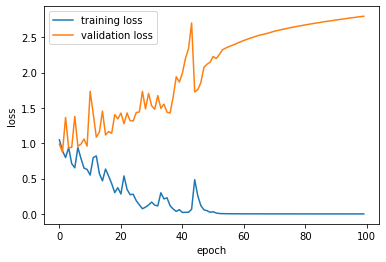

In [19]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')

In [20]:
predictionsTest = LSTM_EEG.predict(lrDataTest)

In [21]:
predictionsTest[predictionsTest>0.5] = 1

In [22]:
predictionsTest[predictionsTest <= 0.5] = 0

In [23]:
comparisonArrayTest = predictionsTest == markerTargetsTest

In [53]:
correctCountTest = 0
for boolValues in comparisonArrayTest:
    if(boolValues[0] & boolValues[1]):
        correctCountTest += 1
falseCountTest = lrDataTest.shape[0] - correctCountTest

predictionsTrain = LSTM_EEG.predict(lrDataTrain)
predictionsTrain[predictionsTrain>0.5] = 1;
predictionsTrain[predictionsTrain<=0.5] = 0;
comparisonArrayTrain = predictionsTrain == markerTargetsTrain;

correctCountTrain = 0
for boolValues in comparisonArrayTrain:
    if(boolValues[0] & boolValues[1] & boolValues[2]):
        correctCountTrain += 1
falseCountTrain = lrDataTrain.shape[0] - correctCountTrain

In [54]:
print("#################################")
print("#################################")
print("Training Performance:\nCorrect MI Prediction: {}\nIncorrect MI Prediction: {}\nPercent Accuracy: {:.3f}%".format(correctCountTrain, falseCountTrain, (correctCountTrain*100/lrDataTrain.shape[0])))
print("#################################")
print("#################################")
print("Testing Performance:\nCorrect MI Prediction: {}\nIncorrect MI Prediction: {}\nPercent Accuracy: {:.3f}%".format(correctCountTest, falseCountTest, (correctCountTest*100/lrDataTest.shape[0])))
print("#################################")
print("#################################")

#################################
#################################
Training Performance:
Correct MI Prediction: 462
Incorrect MI Prediction: 134
Percent Accuracy: 77.517%
#################################
#################################
Testing Performance:
Correct MI Prediction: 144
Incorrect MI Prediction: 112
Percent Accuracy: 56.250%
#################################
#################################


In [26]:
## Applying CSP on the data.
## Test applying CSP on the first channel
exampleLeft = np.transpose(leftData[0])[0:2]
exampleRight = np.transpose(rightData[0])[0:2]
exampleNone = np.transpose(noneData[0])[0:2]
print(exampleLeft.shape)
print(exampleRight.shape)
print(exampleNone.shape)

(2, 170)
(2, 170)
(2, 170)


In [27]:
#Send these two to CSP
filters = CSP(leftDataSub, noneData, rightDataSub)

/opt/conda/envs/py37-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:73: ComplexWarning: Casting complex values to real discards the imaginary part


In [28]:
filtersArray = np.asarray(filters)

In [29]:
filtersArray.shape

(3, 170, 170)

In [30]:
filter1 = filtersArray[0]

In [31]:
filter2 = filtersArray[1]

In [34]:
filter3 = filtersArray[2]

In [32]:
leftData_CSP = np.matmul(np.transpose(filter1), leftDataSub)

In [33]:
rightData_CSP = np.matmul(np.transpose(filter2), rightDataSub)

In [35]:
noneData_CSP = np.matmul(np.transpose(filter3), noneData)

In [37]:
#Construct the target array and merge the data
leftTargets_CSP = np.tile(np.array([1,0,0]),(keep,1))
rightTargets_CSP = np.tile(np.array([0,0,1]), (keep,1))
noneTargets_CSP = np.tile(np.array([0,1,0]), (keep,1))
markerTargets_CSP = np.vstack((leftTargets_CSP, noneTargets_CSP, rightTargets_CSP))
lrData_CSP = np.vstack((leftData_CSP, noneData_CSP, rightData_CSP))

#Sanity Check
print("lrData_CSP Shape: {arg1}\tmarkerTargets_CSP Shape: {arg2}".format(arg1=lrData_CSP.shape, arg2=markerTargets_CSP.shape))

lrData_CSP Shape: (852, 170, 21)	markerTargets_CSP Shape: (852, 3)


In [38]:
## Shuffle the data
lrData_CSP, markerTargets_CSP = shuffle(lrData_CSP, markerTargets_CSP, random_state=0)

In [39]:
## Split into train and test sets
lrDataTrain_CSP, lrDataTest_CSP, markerTargetsTrain_CSP, markerTargetsTest_CSP = train_test_split(lrData_CSP, markerTargets_CSP, test_size=0.3, random_state=1)
markerTargetsTrain_CSP.shape

(596, 3)

In [40]:
## Reshape the data for time-series processing
## Syntax np.reshape((numExamples, numTimeSteps, numInputs/numFeatures))
lrDataTrainRe_CSP = lrDataTrain_CSP.reshape((lrDataTrain_CSP.shape[0], lrDataTrain_CSP.shape[1], lrDataTrain_CSP.shape[2]))
lrDataTestRe_CSP = lrDataTest_CSP.reshape((lrDataTest_CSP.shape[0], lrDataTest_CSP.shape[1], lrDataTest_CSP.shape[2]))


In [41]:
## Construct the model
LSTM_EEG_CSP = Sequential()
LSTM_EEG_CSP.add(LSTM((100),batch_input_shape=(None,lrDataTrainRe_CSP.shape[1], lrDataTrainRe_CSP.shape[2]), return_sequences=True))
LSTM_EEG_CSP.add(LSTM((50), return_sequences=False))
LSTM_EEG_CSP.add(Dense((3),activation='sigmoid'))

In [42]:
LSTM_EEG_CSP.summary()
sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
LSTM_EEG_CSP.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 170, 100)          48800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 79,153
Trainable params: 79,153
Non-trainable params: 0
_________________________________________________________________


In [44]:
history_CSP = LSTM_EEG_CSP.fit(lrDataTrain_CSP, markerTargetsTrain_CSP, epochs=100,verbose=2, batch_size=16, validation_split=.3)

Train on 417 samples, validate on 179 samples
Epoch 1/100
417/417 - 1s - loss: 0.0968 - accuracy: 0.9568 - val_loss: 0.0993 - val_accuracy: 0.9721
Epoch 2/100
417/417 - 1s - loss: 0.0542 - accuracy: 0.9832 - val_loss: 0.1300 - val_accuracy: 0.9553
Epoch 3/100
417/417 - 1s - loss: 0.0502 - accuracy: 0.9856 - val_loss: 0.1963 - val_accuracy: 0.9218
Epoch 4/100
417/417 - 1s - loss: 0.0226 - accuracy: 0.9952 - val_loss: 0.2043 - val_accuracy: 0.9385
Epoch 5/100
417/417 - 1s - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1802 - val_accuracy: 0.9162
Epoch 6/100
417/417 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.1788 - val_accuracy: 0.9274
Epoch 7/100
417/417 - 1s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1790 - val_accuracy: 0.9274
Epoch 8/100
417/417 - 1s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1779 - val_accuracy: 0.9274
Epoch 9/100
417/417 - 1s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1778 - val_accuracy: 0.9274
Epoch 10/100
417/417 - 1s - loss: 0.0018 - ac

In [45]:
predictionsTest_CSP = LSTM_EEG_CSP.predict(lrDataTest_CSP)

In [46]:
predictionsTest_CSP[predictionsTest_CSP>0.5] = 1

In [47]:
predictionsTest_CSP[predictionsTest_CSP <= 0.5] = 0

In [48]:
comparisonArrayTest_CSP = predictionsTest_CSP == markerTargetsTest_CSP

In [51]:
correctCountTest = 0
for boolValues in comparisonArrayTest_CSP:
    if(boolValues[0] & boolValues[1] & boolValues[2]):
        correctCountTest += 1
falseCountTest = lrDataTest_CSP.shape[0] - correctCountTest

predictionsTrain = LSTM_EEG_CSP.predict(lrDataTrain_CSP)
predictionsTrain[predictionsTrain>0.5] = 1;
predictionsTrain[predictionsTrain<=0.5] = 0;
comparisonArrayTrain = predictionsTrain == markerTargetsTrain;

correctCountTrain = 0
for boolValues in comparisonArrayTrain:
    if(boolValues[0] & boolValues[1]):
        correctCountTrain += 1
falseCountTrain = lrDataTrain_CSP.shape[0] - correctCountTrain

In [52]:
print("#################################")
print("#################################")
print("### RESULTS AFTER APPLYING CSP ##")
print("#################################")
print("#################################")
print("#################################")
print("#################################")
print("Training Performance:\nCorrect MI Prediction: {}\nIncorrect MI Prediction: {}\nPercent Accuracy: {:.3f}%".format(correctCountTrain, falseCountTrain, (correctCountTrain*100/lrDataTrain.shape[0])))
print("#################################")
print("#################################")
print("Testing Performance:\nCorrect MI Prediction: {}\nIncorrect MI Prediction: {}\nPercent Accuracy: {:.3f}%".format(correctCountTest, falseCountTest, (correctCountTest*100/lrDataTest.shape[0])))
print("#################################")
print("#################################")

#################################
#################################
### RESULTS AFTER APPLYING CSP ##
#################################
#################################
#################################
#################################
Training Performance:
Correct MI Prediction: 447
Incorrect MI Prediction: 149
Percent Accuracy: 75.000%
#################################
#################################
Testing Performance:
Correct MI Prediction: 60
Incorrect MI Prediction: 196
Percent Accuracy: 23.438%
#################################
#################################
